In [1]:
import torch
import lava.lib.dl.slayer as slayer
import lava.lib.dl.bootstrap as bootstrap
import h5py

         Only Prophesee DVS demo will not run properly.
         Please install it from https://github.com/prophesee-ai/prophesee-automotive-dataset-toolbox


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
import sys
import os
sys.path.append(os.path.join('..', '..', '..' ))

from shared.cifar10_dvs_dataset import CIFAR10DVSData

data_handler = CIFAR10DVSData(save_to='../../../shared/datasets')
data_handler.check_and_download()

train_dataloader, val_dataloader, test_dataloader = data_handler.get_frame_dataloader(batch_size=32, train_ratio=0.7)

c:\Users\xsb24130\AppData\Local\miniconda3\envs\loihi-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CIFAR10DVS Data handler initialized. Data will be saved to '../../../shared/datasets'
Download check complete.
Splited dataset into:
 - Training set: 7000 samples
 - Validation set: 1500 samples
 - Test set: 1500 samples


Shape of a frame-based data batch: torch.Size([32, 1, 32, 32])
Labels of the batch: tensor([9, 2, 4, 2, 0, 3, 1, 1, 3, 7, 9, 6, 3, 7, 3, 3, 5, 6, 0, 6, 3, 2, 9, 1,
        6, 4, 2, 5, 0, 6, 4, 7])


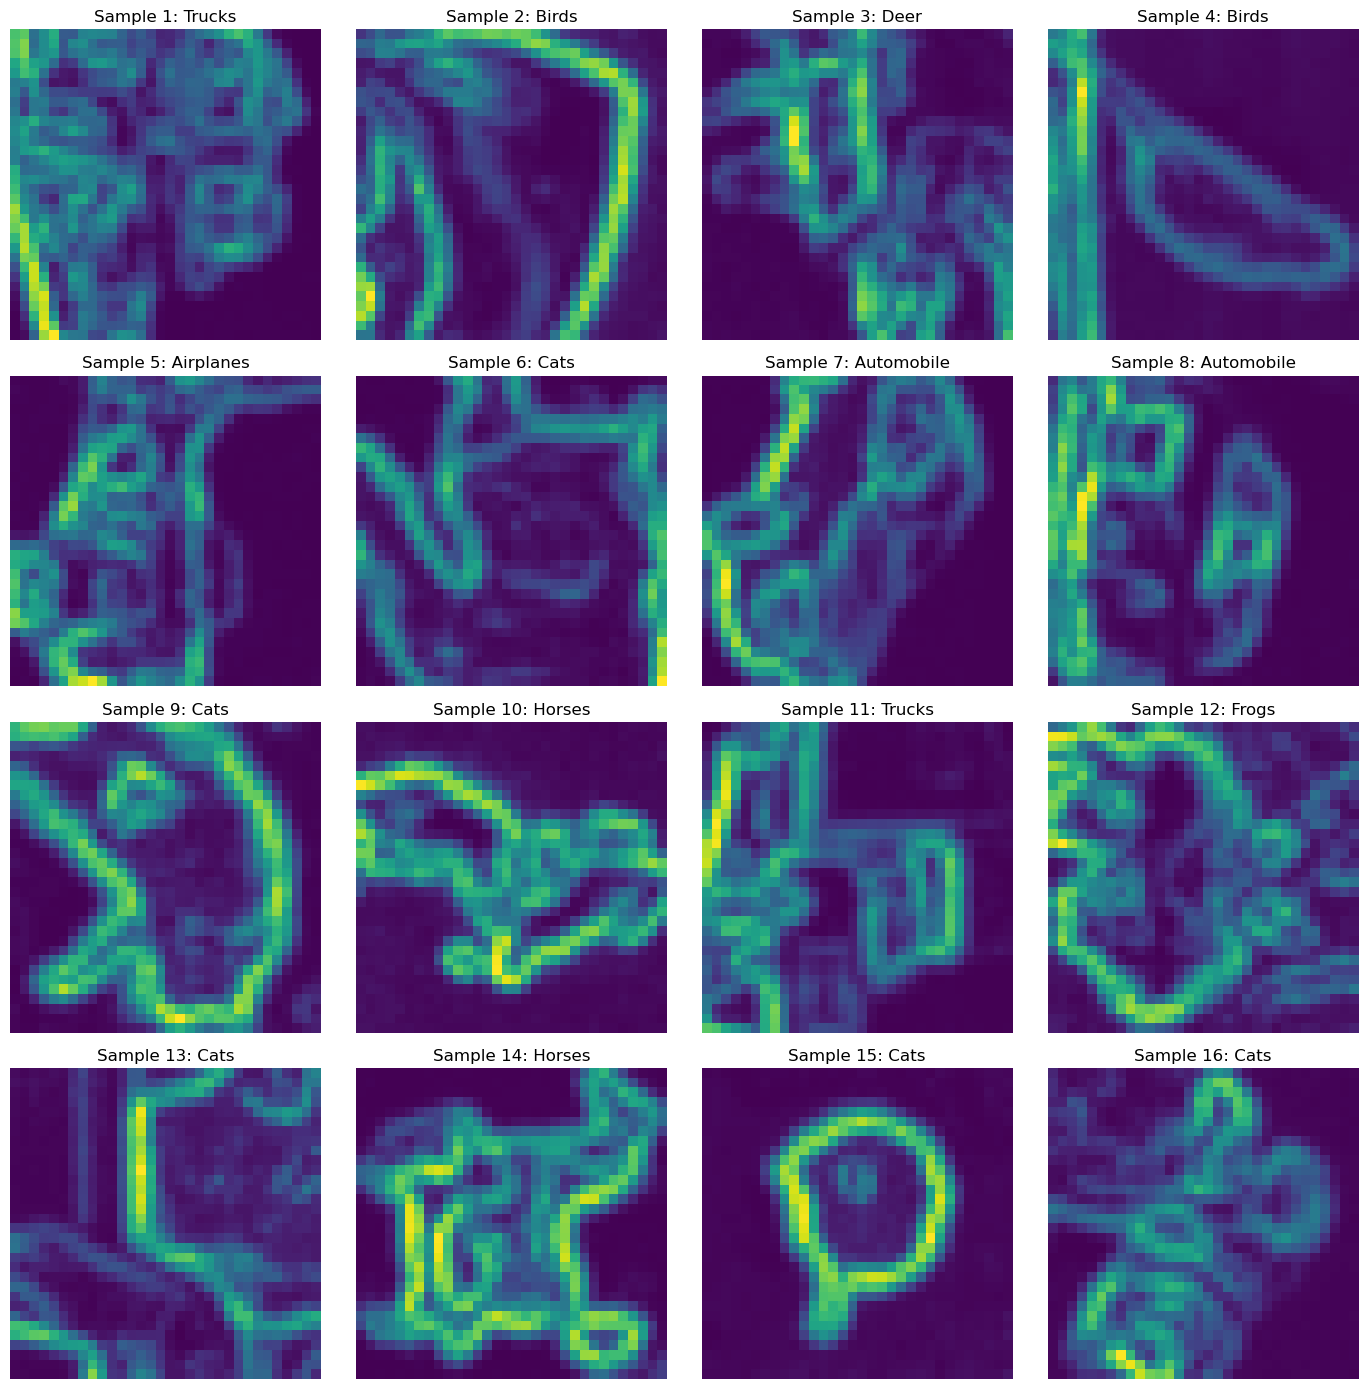

In [4]:
import matplotlib.pyplot as plt

# Get one batch from the train_dataloader
samples, labels = next(iter(train_dataloader))
print(f"Shape of a frame-based data batch: {samples.shape}")
print(f"Labels of the batch: {labels}")


batch_size = samples.shape[0]
fig, axes = plt.subplots(4, 4, figsize=(14, 14))  # For batch_size=16
axes = axes.flatten()

for i in range(16):
    sample_img = samples[i, 0]  # shape: [H, W]
    ax = axes[i]
    ax.imshow(sample_img)
    label_index = labels[i].item()
    label_name = data_handler.labels[label_index]
    ax.set_title(f"Sample {i+1}: {label_name}", fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [5]:
datas, labels = next(iter(train_dataloader))
print(f"Data shape: {datas.shape}, Label shape: {labels.shape}")

Data shape: torch.Size([32, 1, 32, 32]), Label shape: torch.Size([32])


In [16]:
import torch
import torch.nn as nn

class VGG9Bootstrap(torch.nn.Module):
    def __init__(self, time_steps=16):
        super().__init__()
        self.time_steps = time_steps

        neuron_params = {
            'threshold': 1.25,
            'current_decay': 1,
            'voltage_decay': 0.03,
            'tau_grad': 1,
            'scale_grad': 1,
        }
        neuron_params_norm = {
            **neuron_params,
            # 'norm': slayer.neuron.norm.MeanOnlyBatchNorm,
        }

        self.blocks = torch.nn.ModuleList([
            
            bootstrap.block.cuba.Input(neuron_params, weight=1, bias=0),
            
            bootstrap.block.cuba.Dense(neuron_params_norm, 32*32, 64, weight_norm=True, weight_scale=2),
            bootstrap.block.cuba.Dense(neuron_params_norm, 64, 64, weight_norm=True, weight_scale=2),
            
            bootstrap.block.cuba.Dense(neuron_params_norm, 64, 128, weight_norm=True, weight_scale=2),
            bootstrap.block.cuba.Dense(neuron_params_norm, 128, 128, weight_norm=True, weight_scale=2),
            bootstrap.block.cuba.Dense(neuron_params_norm, 128, 256, weight_norm=True, weight_scale=2),
           
            bootstrap.block.cuba.Dense(neuron_params_norm, 256, 256, weight_norm=True, weight_scale=2),
            bootstrap.block.cuba.Affine(neuron_params, 256, 10, weight_norm=True, weight_scale=2),
        ])

    def forward(self, x, mode):
        N, C, H, W = x.shape
        if mode.base_mode == bootstrap.Mode.ANN:
            x = x.reshape([N, C, H, W, 1])
        else:
            x = slayer.utils.time.replicate(x, self.time_steps)

        x = x.reshape(N, -1, x.shape[-1])

        for block, m in zip(self.blocks, mode):
            x = block(x, mode=m)

        return x

    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        simulation = h.create_group('simulation')
        simulation['Ts'] = 1
        simulation['tSample'] = self.time_steps        
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))

In [ ]:
net = VGG9Bootstrap().to(device)

c:\Users\xsb24130\AppData\Local\miniconda3\envs\loihi-env\lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [18]:
trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)

In [30]:
stats = slayer.utils.LearningStats()
scheduler = bootstrap.routine.Scheduler()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [20]:
from shared.system_monitor import SystemMonitor

monitor = SystemMonitor(sample_interval=1.0)

In [ ]:
import torch.nn.functional as F

monitor.start()

epochs = 10
for epoch in range(epochs):
    for i, (input, label) in enumerate(train_dataloader, 0):
        net.train()
        mode = scheduler.mode(epoch, i, net.training)

        input = input.to(device)
        output = net.forward(input, mode)
        rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

        loss = F.cross_entropy(rate, label.to(device))
        prediction = rate.data.max(1, keepdim=True)[1].cpu().flatten()

        stats.training.num_samples += len(label)
        stats.training.loss_sum += loss.cpu().data.item() * input.shape[0]
        stats.training.correct_samples += torch.sum( prediction == label ).data.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

    for i, (input, label) in enumerate(test_dataloader, 0):
        net.eval()
        mode = scheduler.mode(epoch, i, net.training)

        with torch.no_grad():
            input = input.to(device)
            output = net.forward(input, mode=scheduler.mode(epoch, i, net.training))
            rate = torch.mean(output, dim=-1).reshape((input.shape[0], -1))

            loss = F.cross_entropy(rate, label.to(device))
            prediction = rate.data.max(1, keepdim=True)[1].cpu().flatten()

        stats.testing.num_samples += len(label)
        stats.testing.loss_sum += loss.cpu().data.item() * input.shape[0]
        stats.testing.correct_samples += torch.sum( prediction == label ).data.item()

    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

    if mode.base_mode == bootstrap.routine.Mode.SNN:
        scheduler.sync_snn_stat(stats.testing)
        print('\r', ' '*len(f'\r[Epoch {epoch:2d}/{epochs}] {stats}'))
        print(mode)
        print(f'[Epoch {epoch:2d}/{epochs}]\nSNN Testing: {scheduler.snn_stat}')

        if scheduler.snn_stat.best_accuracy:
            torch.save(net.state_dict(), 'vgg9-loihi.pt')
        scheduler.update_snn_stat()
            
    stats.update()
    stats.save(trained_folder + '/')

monitor.stop()

System monitor started.


c:\Users\xsb24130\AppData\Local\miniconda3\envs\loihi-env\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\xsb24130\AppData\Local\miniconda3\envs\loihi-env\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


                                                                                                                                                             
Mode: SNN
[Epoch  0/10]
SNN Testing: loss =     2.30258                          accuracy = 0.09733 
[Epoch  9/10] Train loss =     2.30258 (min =     2.30258)     accuracy = 0.10114 (max = 0.10114)  | Test  loss =     2.30258 (min =     2.30258)     accuracy = 0.09733 (max = 0.09733) System monitor stopped.


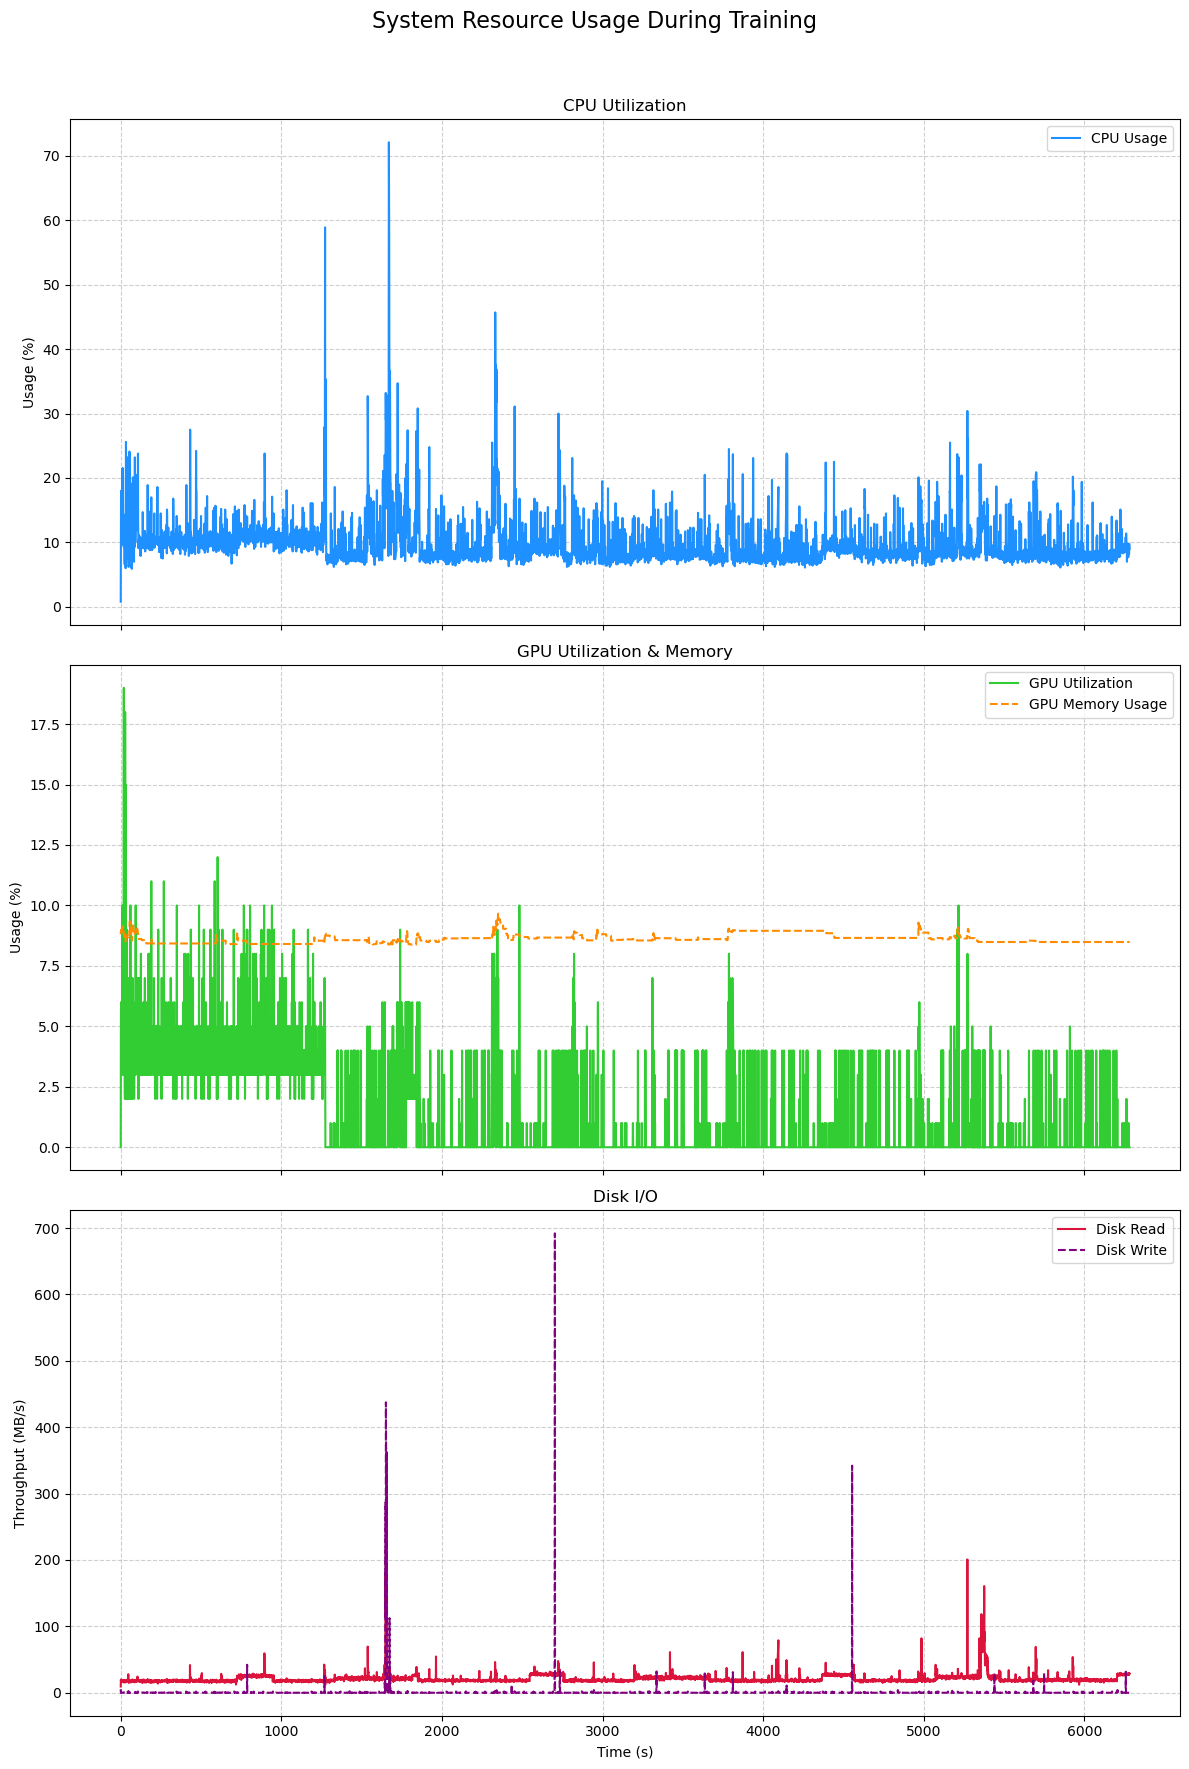

In [22]:
monitor.plot_results()

In [40]:
print(monitor.cpu_percent)
print(monitor.gpu_percent)
print(monitor.gpu_mem_percent)
print(monitor.timestamps)

import pandas as pd

data_to_save = {
    'Timestamp': monitor.timestamps,
    'CPU_Usage_Percent': monitor.cpu_percent,
    'GPU_Usage_Percent': monitor.gpu_percent,
}

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame(data_to_save)

# Define the output filename
output_filename = 'system_monitoring_data_loihi.csv'

# Save the DataFrame to a CSV file
# The index=False part prevents pandas from writing row numbers into the file
df.to_csv(output_filename, index=False)

[0.8, 13.0, 18.0, 12.5, 9.9, 10.1, 9.7, 10.3, 12.8, 15.5, 21.5, 17.5, 19.4, 19.2, 21.5, 14.6, 13.4, 9.7, 9.4, 11.8, 14.3, 11.8, 10.5, 7.2, 6.6, 6.8, 10.2, 6.6, 9.4, 6.8, 6.0, 9.9, 25.6, 14.3, 7.7, 7.3, 7.9, 13.0, 14.3, 19.2, 13.3, 21.2, 22.9, 17.5, 13.5, 9.1, 16.3, 23.3, 6.2, 7.1, 7.0, 9.6, 15.3, 24.1, 23.6, 14.3, 12.8, 7.7, 10.3, 16.5, 13.1, 12.7, 6.2, 6.1, 6.9, 8.0, 6.7, 6.6, 5.9, 7.2, 11.0, 17.7, 19.2, 14.8, 20.1, 18.1, 12.3, 16.5, 17.5, 9.5, 8.2, 7.0, 11.8, 12.2, 10.1, 9.3, 23.2, 17.2, 19.1, 10.0, 11.9, 17.7, 14.1, 18.5, 19.1, 15.3, 13.2, 14.7, 13.4, 20.5, 19.3, 15.0, 17.8, 11.9, 14.4, 23.8, 13.2, 10.3, 9.1, 10.3, 10.0, 10.6, 11.1, 9.2, 10.9, 10.9, 9.4, 10.6, 9.1, 8.1, 9.9, 7.9, 9.4, 10.4, 9.7, 10.0, 10.1, 10.3, 9.6, 9.7, 10.1, 9.2, 10.7, 10.3, 14.7, 10.5, 9.1, 9.9, 9.6, 10.3, 10.1, 11.1, 10.3, 9.4, 9.1, 10.0, 11.8, 9.6, 10.0, 8.6, 9.7, 10.3, 9.2, 11.2, 9.1, 9.9, 9.5, 10.7, 9.9, 10.3, 10.4, 9.4, 10.7, 9.2, 18.9, 10.2, 11.4, 10.1, 10.2, 9.0, 10.1, 10.0, 14.8, 11.0, 9.9, 9.3, 10.4, 1

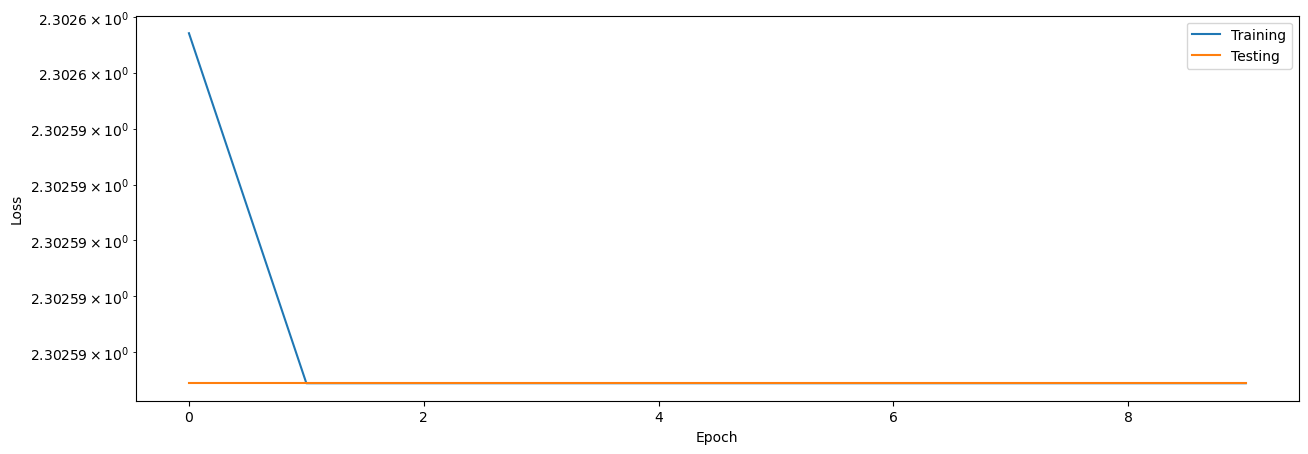

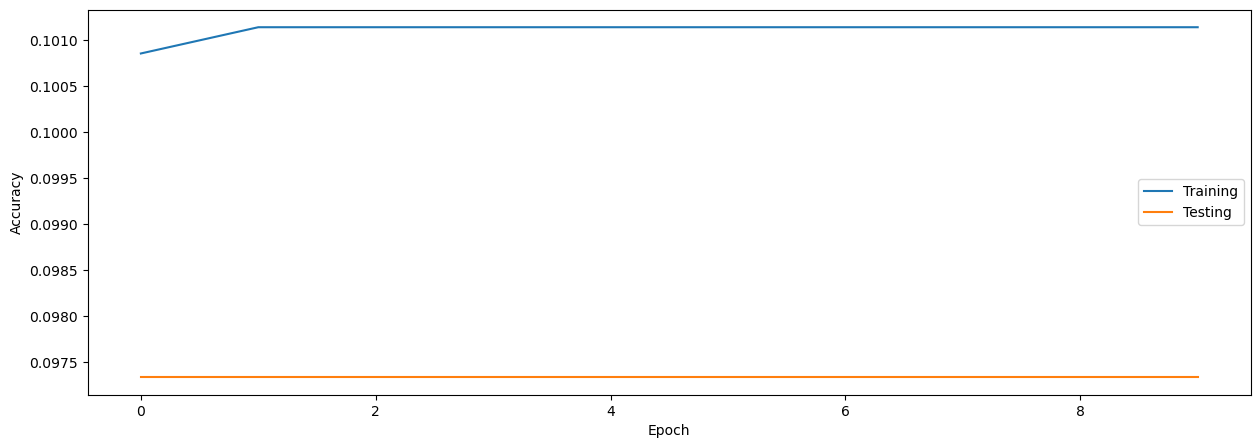

In [23]:
stats.plot(figsize=(15, 5))

In [ ]:
net.load_state_dict(torch.load('vgg9-loihi.pt'))
net.export_hdf5('vgg9-loihi.net')

In [35]:
from matplotlib import animation
from PIL import Image

os.makedirs('../gifs/', exist_ok=True)

output = net(input.to(device), mode=scheduler.mode(100, 0, False))
for i in range(5):
    img = (2*input[i].reshape(32, 32).cpu().data.numpy()-1) * 255
    Image.fromarray(img).convert('RGB').save(f'../gifs/inp{i}.png')
    spike_tensor = output[i].cpu().data.numpy().reshape(1, 10, -1)
    if spike_tensor.sum() > 0:
        out_event = slayer.io.tensor_to_event(spike_tensor)
        out_anim = out_event.anim(plt.figure(figsize=(10, 3.5)), frame_rate=2400)
        out_anim.save(f'../gifs/out{i}.gif', animation.PillowWriter(fps=24), dpi=300)
    else:
        print(f"No spikes for sample {i}, skipping event animation.")

No spikes for sample 0, skipping event animation.
No spikes for sample 1, skipping event animation.
No spikes for sample 2, skipping event animation.
No spikes for sample 3, skipping event animation.
No spikes for sample 4, skipping event animation.


In [ ]:
img_td = lambda gif: f'<td> <img src="{gif}" alt="Drawing" style="height: 150px;"/> </td>'
html = '<table>'
html += '<tr><td align="center"><b>Input</b></td><td><b>Output</b></td></tr>'
for i in range(5):
    html += '<tr>'
    html += img_td(f'gifs/inp{i}.png')
    html += img_td(f'gifs/out{i}.gif')
    html += '</tr>'
html += '</tr></table>'
display.HTML(html)